In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from tensorflow.keras import mixed_precision


2024-11-24 22:25:36.892341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732469136.938562   89423 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732469136.951952   89423 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 22:25:37.065626: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mixed_precision.set_global_policy('mixed_float16')

In [3]:
X=np.load(os.path.join(os.path.dirname(os.getcwd()), 'dataset_prep','all_ratio','ratio_X.npy'))
X.shape

(8666, 20, 5)

In [5]:
y=np.load(os.path.join(os.path.dirname(os.getcwd()), 'dataset_prep','all_ratio','ratio_y.npy'))
y.shape

(8666,)

In [6]:
y=np.reshape(y,(8666,1))
y.shape


(8666, 1)

In [7]:
X.shape

(8666, 20, 2)

In [8]:
train_size=int(0.9*len(X))
val_size=int(0.05*len(X))

In [9]:
# input_dataset = tf.data.Dataset.from_tensor_slices((X))
# output_dataset = tf.data.Dataset.from_tensor_slices((y))

In [10]:
# dataset = tf.data.Dataset.zip((input_dataset, output_dataset))
dataset = tf.data.Dataset.from_tensor_slices((X, y))

I0000 00:00:1732469190.666320   89423 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9580 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:29:00.0, compute capability: 8.6


In [11]:
dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=8666>

In [12]:
batch_size = 32

In [13]:
dataset = dataset.shuffle(buffer_size=dataset.cardinality().numpy())

In [14]:
train_dataset=dataset.take(train_size)
val_dataset=dataset.skip(train_size).take(val_size)
test_dataset=dataset.skip(train_size+val_size)

In [15]:
print(f'train_dataset: {train_dataset.cardinality()}, val_dataset: {val_dataset.cardinality()}, test_dataset: {test_dataset.cardinality()}')

train_dataset: 7799, val_dataset: 433, test_dataset: 434


In [16]:
train_dataset = (train_dataset
                 .shuffle(buffer_size=train_dataset.cardinality().numpy())
                 .batch(batch_size=batch_size)
                 .prefetch(tf.data.AUTOTUNE)
                 )

In [17]:
train_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=244>

In [18]:
val_dataset=(val_dataset
             .shuffle(buffer_size=val_dataset.cardinality().numpy())
             .batch(batch_size=batch_size)
             )

In [19]:
test_dataset=(test_dataset
              .shuffle(buffer_size=test_dataset.cardinality().numpy())
                .batch(batch_size=batch_size)
                )

In [20]:
for x_batch, y_batch in train_dataset.take(1):
    input_shape = x_batch.shape[:]  # Extract shape of a single batch's inputs
    print(f"Input shape for the model: {input_shape}")

Input shape for the model: (32, 20, 2)


2024-11-24 22:26:42.085330: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
input_shape

TensorShape([32, 20, 2])

In [ ]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[20,5]),
    tf.keras.layers.LSTM(128, activation='tanh',return_sequences=True,dropout=0.2),
    tf.keras.layers.LSTM(64, activation='tanh',return_sequences=True,dropout=0.2 ),
    tf.keras.layers.LSTM(32, activation='tanh',return_sequences=False, ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
epochs = 400

In [26]:
history = model.fit(
    train_dataset,  
    validation_data=val_dataset, 
    epochs=epochs
)

Epoch 1/400


I0000 00:00:1732469219.827128   89926 cuda_dnn.cc:529] Loaded cuDNN version 90300


244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.9750 - mean_squared_error: 0.9748 - val_loss: 0.8324 - val_mean_squared_error: 0.8323
Epoch 2/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1191 - mean_squared_error: 1.1190 - val_loss: 1.2441 - val_mean_squared_error: 1.2440
Epoch 3/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1576 - mean_squared_error: 1.1574 - val_loss: 1.1099 - val_mean_squared_error: 1.1097
Epoch 4/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0327 - mean_squared_error: 1.0326 - val_loss: 1.0974 - val_mean_squared_error: 1.0975
Epoch 5/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9960 - mean_squared_error: 0.9960 - val_loss: 0.7171 - val_mean_squared_error: 0.7172
Epoch 6/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0342 - mean_squared_error: 1.0340 - val_loss: 0.7146 - val_mean_squared_error: 0.7147
Epoch 7/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0903 - mean_squared_error: 1.0902 - val_loss: 0.7029 -

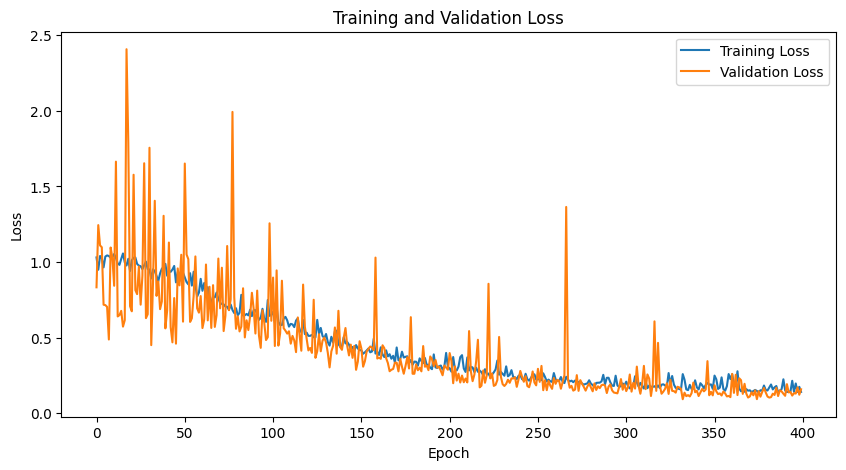

In [27]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'][:], label='Training Loss')
plt.plot(history.history['val_loss'][:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
model.evaluate(test_dataset)

 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0626 - mean_squared_error: 0.0626

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5260 - mean_squared_error: 0.5260 


[1.2757898569107056, 1.2755833864212036]

In [30]:
model.save(os.path.join(os.path.dirname(os.getcwd()), 'models','ratio_lstm_model.keras'))